## Pré-processamento e explocação do Modelo de Classificação

In [ ]:
# Imports
import os
import re
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display
%matplotlib inline

### Baixar os dados do [Fake.br-Corpus](https://github.com/roneysco/Fake.br-Corpus)

*Atenção:* Para rodar localmente, é preciso salvar o pacote Fake.br-Corpus no diretorio do projeto.

In [ ]:
!git clone https://github.com/roneysco/Fake.br-Corpus

Cloning into 'Fake.br-Corpus'...
remote: Enumerating objects: 28763, done.
remote: Total 28763 (delta 0), reused 0 (delta 0), pack-reused 28763
Receiving objects: 100% (28763/28763), 37.10 MiB | 21.02 MiB/s, done.
Resolving deltas: 100% (14129/14129), done.
Checking out files: 100% (21602/21602), done.


### Carregando os dados

Vou utilizar a amostra "size_normalized_texts" do Corpus dado que ela ajuda a evitar viéses no treino, conforme informação disponível na documentação. Cada par de texto verdadeiro ou falso possui a mesma quantidade de palavras, truncando o maior pelo menor.

In [ ]:
DADOS_CAMINHO = "./Fake.br-Corpus/size_normalized_texts"

def load_txts(path):
    txts = []
    for filename in sorted(os.listdir(path), key=lambda x: int(re.match("[0-9]+", x).group())):
        with open(os.path.join(path, filename)) as f:
            txts.append(f.read())
    return [txt.rstrip() for txt in txts]

true_txts = load_txts(os.path.join(DADOS_CAMINHO, "true"))
fake_txts = load_txts(os.path.join(DADOS_CAMINHO, "fake"))

#confere se tem a mesma quantidade (dataset é balanceado)
assert(len(true_txts) == len(fake_txts))

dados = pd.DataFrame(
    [{"texto": t, "classe": 0} for t in true_txts] \
         + [{"texto": f, "classe": 1}  for f in fake_txts]
)
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 200)
display(dados[dados['texto'].str.len()<100].sample(n=3)[['classe', 'texto']])

,classe,texto
2424,0,Esplanada dos Ministérios é fechada para Fórum Mundial da Água. Trânsito na área
4841,1,Ministro do STF manda afastar Aécio do cargo de senador. .
5066,1,Divulgada a segunda lista de Janot com nomes de 22 políticos. .


### Exploração e limpeza de dados

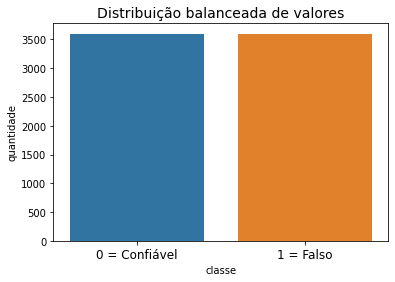

In [ ]:
ax = sns.countplot(x="classe", data=dados)
ax.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
ax.set_title('Distribuição balanceada de valores', fontsize=14)
ax.set_ylabel('quantidade')
plt.show()

In [ ]:
def distribuicao_palavras(texto):
    qtdes = []
    for linha in texto:
        qtdes.append(len(re.findall(r"[\w']+|[.,!?;:/\"]", linha)))
    return np.array(qtdes)

def distribiucao_palavras(dados, campo, titulo):
    contagem = distribuicao_palavras(dados[campo].values)
    intervalo = list(range(0, 601, 50))

    plt.figure(figsize=(8,6))
    plt.rcParams.update({'font.size': 14})
    plt.hist(contagem, rwidth=0.9, edgecolor='black', linewidth=1, bins=intervalo)
    plt.xticks(intervalo)
    plt.title(titulo)
    plt.xlabel("Qtde palavras ou pontuação", fontsize=14, fontweight="bold")
    plt.ylabel("Frequência", fontsize=14, fontweight="bold")

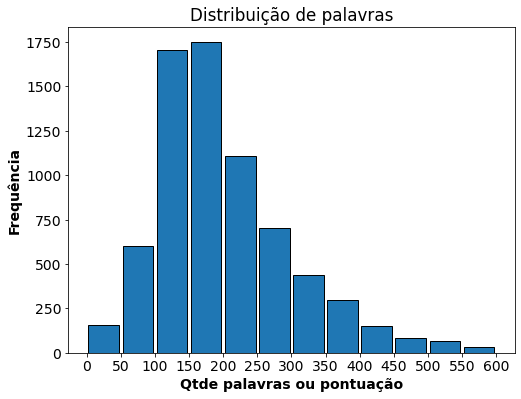

In [ ]:
distribiucao_palavras(dados, "texto", "Distribuição de palavras")

In [ ]:
# Limpar textos
def limpar_textos(texto):
    texto = str(texto).replace(r'http[\w:/\.]+', ' ')  # remover urls
    texto = str(texto).replace(r'[^\.\w\s]', ' ')  # remover tudo exceto caracters e pontuação
    # Correção das pontuações duplicadas, há muitos casos no dadaset
    texto = re.sub(r'(\W)(?=\1)', '', str(texto)).replace(". .", ".")
    texto = str(texto).replace('[^a-zA-Z]', ' ')
    texto = str(texto).replace(r'\s\s+', ' ')
    return texto.strip()

dados["texto_limpo"] = dados.texto.apply(limpar_textos)
dados.sample(n=5)

,texto,classe,texto_limpo
890,"Barroso diz que intervenção federal não resolverá problema da criminalidade no Rio. Para ministro do STF, solução é social e de reconquista de espaços que foram perdidos. RIO - Para o ministro do ...",0,"Barroso diz que intervenção federal não resolverá problema da criminalidade no Rio. Para ministro do STF, solução é social e de reconquista de espaços que foram perdidos. RIO - Para o ministro do ..."
512,"'Não existe país que esteja acima do bem e do mal', diz Patriota. Brasil, Índia e África do Sul estão negociando 'gestão diplomática' junto ao governo Sírio; se houver moção pró-independência pale...",0,"'Não existe país que esteja acima do bem e do mal', diz Patriota. Brasil, Índia e África do Sul estão negociando 'gestão diplomática' junto ao governo Sírio; se houver moção pró-independência pale..."
488,"Um dos personagens favoritos de minha pré-adolescência em Campina Grande foi o bodegueiro Joca Leite. Dono de uma tarimba (box) com mercadorias variadas à venda no Mercado Municipal da Prata, bair...",0,"Um dos personagens favoritos de minha pré-adolescência em Campina Grande foi o bodegueiro Joca Leite. Dono de uma tarimba (box) com mercadorias variadas à venda no Mercado Municipal da Prata, bair..."
1078,"Segunda-feira, 26 de fevereiro de 2018. Boa noite! Aqui estão as principais notícias para você terminar o dia bem-informado. A temporada 2018 do Imposto de Renda ainda não começou oficialmente, ma...",0,"Segunda-feira, 26 de fevereiro de 2018. Boa noite! Aqui estão as principais notícias para você terminar o dia bem-informado. A temporada 2018 do Imposto de Renda ainda não começou oficialmente, ma..."
4825,"A frieza, a prepotência e a ironia de Joesley: ""Pode comprar 5 deputados por 30 milhões. É por minha conta"". Empresário mostra como comprou deputados para evitar o impeachment de Dilma. 2:22 min...",1,"A frieza, a prepotência e a ironia de Joesley: ""Pode comprar 5 deputados por 30 milhões. É por minha conta"". Empresário mostra como comprou deputados para evitar o impeachment de Dilma. 2:22 min ""..."


In [ ]:
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 21.2 MB 5.2 MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186281 sha256=e73579138ff99369bb19366532b1cdb2e089bbe8a65f5deaa64285b18bbee6d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-jqnnyrdc/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [ ]:
# Processamento com Spacy
import pt_core_news_sm
nlp = pt_core_news_sm.load()

# Lemmatizer (o resultado é a raiz da palavra que existe na gramática, mantendo o contexto)
# Stemming (palavra resultante pode não existir, apenas reduz a dimencionalidade) 

# Remover stopwords, pontuação e lematizar 
def processo_spacy(texto):
    retorno = []
    for token in nlp(texto): 
      if not (token.is_stop or token.is_punct):
        retorno.append(token.lemma_)
    return " ".join(retorno)

dados["texto_processado"] = dados.texto_limpo.apply(processo_spacy)

In [ ]:
# Confere resultados visualmente
dados.sample(n=5)

,texto,classe,texto_limpo,texto_processado
715,"‘EUA conhecem bem Kim Jong-Un, imprevisível é Trump’, diz ex-CIA e especialista em Coreia do Norte. Ex-funcionária da inteligência americana diz que líder norte-coreano é tudo menos louco e afirma...",0,"‘EUA conhecem bem Kim Jong-Un, imprevisível é Trump’, diz ex-CIA e especialista em Coreia do Norte. Ex-funcionária da inteligência americana diz que líder norte-coreano é tudo menos louco e afirma...",EUA conhecer Kim Jong-Un imprevisível Trump ex-CIA e especialista Coreia Norte Ex-funcionária inteligência americano líder norte-coreano louco e afirmar tom bélico Trump guerra Pyongyang contribui...
1050,A decisão da Segunda Turma do Supremo Tribunal Federal (STF) de conceder habeas corpus ao criminoso condenado em dois processos a 32 anos de prisão e denunciado pelo Ministério Público Federal no ...,0,A decisão da Segunda Turma do Supremo Tribunal Federal (STF) de conceder habeas corpus ao criminoso condenado em dois processos a 32 anos de prisão e denunciado pelo Ministério Público Federal no ...,A decisão Turma Supremo Tribunal Federal STF conceder habeas corpus o o criminoso condenar processo o 32 ano prisão e denunciar Ministério Público Federal prático crime 36 atos lavagem dinheiro 3 ...
7076,"Australianos são presos por posse de explosivos em avião da Gol. Destino seria São Paulo. As prisões ocorreram no aeroporto na cidade de Santa Cruz de La Sierra, Bolívia. O Jornal boliviano El ...",1,"Australianos são presos por posse de explosivos em avião da Gol. Destino seria São Paulo. As prisões ocorreram no aeroporto na cidade de Santa Cruz de La Sierra, Bolívia. O Jornal boliviano El Deb...",Australianos preso posse explosivo avião Gol Destino Paulo prisão ocorrer aeroporto cidade Santa Cruz La Sierra Bolívia O Jornal boliviano El Deber informar preso suspeito cidadania australiano ac...
4403,"Joesley xingando o Supremo: ""Nós precisamos organizar o STF. Como é que a gente grampeia esses FPD?"". . Joesley Batista falando sobre o ex-ministro petista: ""Surtou por causa do Zé, porque sabe q...",1,"Joesley xingando o Supremo: ""Nós precisamos organizar o STF. Como é que a gente grampeia esses FPD?"". Joesley Batista falando sobre o ex-ministro petista: ""Surtou por causa do Zé, porque sabe que,...",Joesley xingar o Supremo precisar organizar o STF o gente grampear FPD Joesley Batista falar o ex-ministro petista Surtou causar Zé entregar o Zé entregar o Supremo Joesley áudio referir o José Ed...
3219,Brasileiro vira chef da maconha no Uruguai e faz até jantar para idosos. Gustavo Colombeck diz que já recebeu proposta para trabalhar na Europa e chega a atender grupos de até 130 pessoas - mas so...,0,Brasileiro vira chef da maconha no Uruguai e faz até jantar para idosos. Gustavo Colombeck diz que já recebeu proposta para trabalhar na Europa e chega a atender grupos de até 130 pessoas - mas so...,Brasileiro virar chef maconha Uruguai e jantar idoso Gustavo Colombeck receber proposto trabalhar Europa e chegar o atender grupo 130 pessoa sonhar o erva ser liberar STF poder cozinhar Brasil pra...


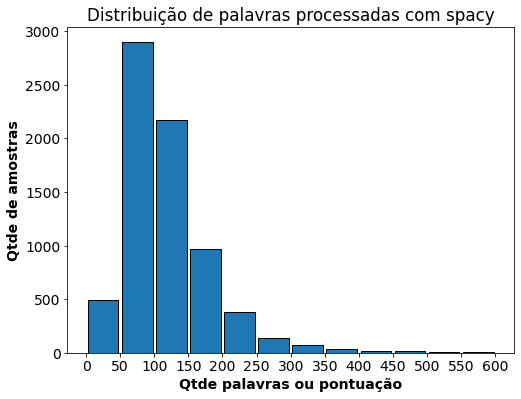

In [ ]:
# A distribuição mudou e temo ter problemas de viés com a frases mais longas
distribiucao_palavras(dados, "texto_processado", "Distribuição de palavras processadas com spacy")

In [ ]:
dados["qtde_texto_limpo"] = dados.texto_limpo.apply(lambda texto: len(re.findall(r"[\w']+|[.,!?;:/\"]", texto)))
dados["qtde_texto_processado"] = dados.texto_processado.apply(lambda texto: len(re.findall(r"[\w']+|[.,!?;:/\"]", texto)))
dados.sample(n=5)

,texto,classe,texto_limpo,texto_processado,qtde_texto_limpo,qtde_texto_processado
1898,"Veja repercussão de reportagem sobre gravação envolvendo Temer. Dono da JBS gravou presidente dando aval para comprar silêncio de Cunha, diz jornal. Planalto nega que Temer tenha tentado evitar de...",0,"Veja repercussão de reportagem sobre gravação envolvendo Temer. Dono da JBS gravou presidente dando aval para comprar silêncio de Cunha, diz jornal. Planalto nega que Temer tenha tentado evitar de...",repercussão reportagem gravação envolver Temer Dono JBS gravar presidente dar aval comprar silêncio Cunha jornal Planalto negar Temer ter tentar evitar delação político Donos frigorífico JBS dizer...,203,123
5323,"Nova operação da PF poderá ser o estopim para que Eduardo Cunha comece a jogar lama no ventilador. Deflagrada na última sexta-feira (13) a Operação Cui Bono (da PF), poderá ser o último ""incentiv...",1,"Nova operação da PF poderá ser o estopim para que Eduardo Cunha comece a jogar lama no ventilador. Deflagrada na última sexta-feira (13) a Operação Cui Bono (da PF), poderá ser o último ""incentivo...",operação PF o estopim Eduardo Cunha começar o jogar lama ventilador Deflagrada último sexta-feira 13 o Operação Cui Bono PF o incentivar o ex-presidente Câmara Eduardo Cunha fazer delação premiar ...,221,123
2452,São Paulo abriga 1/3 das salas de cinema do país. Estado tem 1.031 espaços de exibição; dados mostram concentração de salas no Sudeste. Acre aparece na última posição do ranking.. Uma em cada três...,0,São Paulo abriga 1/3 das salas de cinema do país. Estado tem 1.031 espaços de exibição; dados mostram concentração de salas no Sudeste. Acre aparece na última posição do ranking. Uma em cada três ...,Paulo abrigar 1/3 sala cinema país 1.031 espaço exibição dar mostrar concentração sala Sudeste Acre aparecer último ranking sala cinema Brasil localizar Paulo 1.031 espaço O melhorar concentração ...,230,118
2398,"‘Estou morta. Morri. Me mataram em vida’. Estuprada aos 36 anos, Maria viu a vida ruir e durante cinco anos lutou na Justiça pela condenação do acusado. Às 14h56 de uma quarta-feira de agosto, Mar...",0,"‘Estou morta. Morri. Me mataram em vida’. Estuprada aos 36 anos, Maria viu a vida ruir e durante cinco anos lutou na Justiça pela condenação do acusado. Às 14h56 de uma quarta-feira de agosto, Mar...",morto Morri matar vidar Estuprada o 36 ano Maria ver o vidar ruir e durante ano lutar Justiça condenação acusar 14h56 quarta-feira agostar Maria entrar só sala 318 Fórum Criminal Barra Funda zonar...,400,229
367,Diretório Nacional do PT suspende Palocci por 60 dias após acusação contra Lula. Suspensão foi definida na tarde desta sexta-feira (22). Segundo senadora Gleisi Hoffmann Palocci mentiu para reduzi...,0,Diretório Nacional do PT suspende Palocci por 60 dias após acusação contra Lula. Suspensão foi definida na tarde desta sexta-feira (22). Segundo senadora Gleisi Hoffmann Palocci mentiu para reduzi...,Diretório Nacional PT suspender Palocci 60 dia acusação Lula Suspensão definir d sexta-feira 22 senador Gleisi Hoffmann Palocci mentir reduzir peno e suspensão estatuto partir O ex-ministro Antoni...,76,52


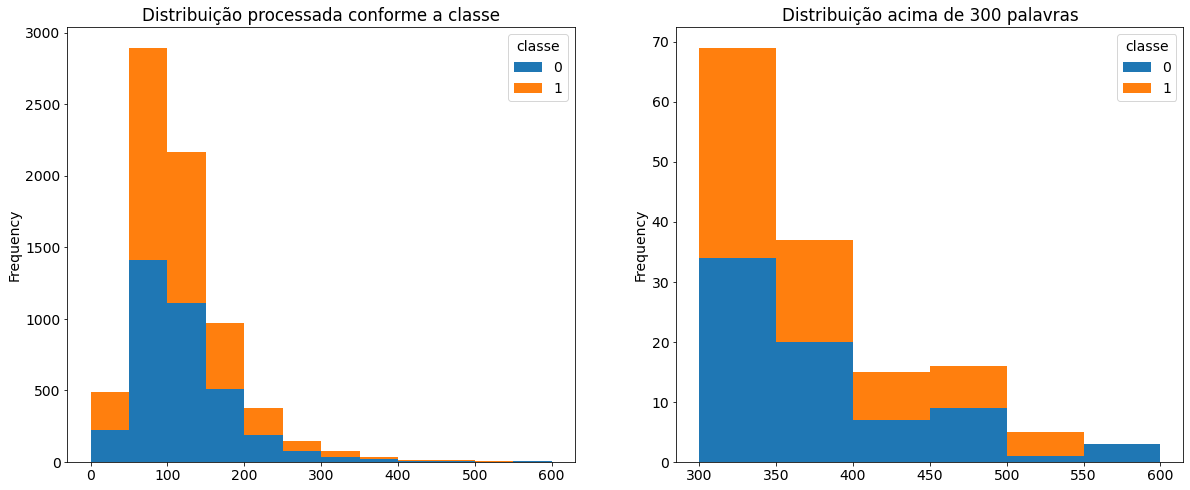

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

axes1 = dados.pivot(columns='classe').qtde_texto_processado.plot(ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 601, 50)), title="Distribuição processada conforme a classe", layout=(1,2))
evitar_bias = dados[dados['qtde_texto_processado'] > 300]
axes2 = evitar_bias.pivot(columns='classe').qtde_texto_processado.plot(ax=axes[1], kind='hist', stacked=True, bins=list(range(300, 601, 50)), title="Distribuição acima de 300 palavras", layout=(1,2))


In [ ]:
display(f"Total de amostras: {dados.shape[0]}", f"Amostras com muitas palavras: {evitar_bias.shape[0]}")
display(evitar_bias.groupby('classe').qtde_texto_processado.count())

'Total de amostras: 7200'

'Amostras com muitas palavras: 158'

classe
0    80
1    78
Name: qtde_texto_processado, dtype: int64

In [ ]:
dados[(dados['qtde_texto_processado'] < 400)].groupby('classe').qtde_texto_processado.count()

classe
0    3574
1    3574
Name: qtde_texto_processado, dtype: int64

In [ ]:
# Encontrei um ponto de corte que manteve o balanceamento perfeito da base
dados = dados[(dados['qtde_texto_processado'] < 400)]

### Pesquisando se alguma palavra se destaca demais e pode gerar viés

In [ ]:
wordcloud = WordCloud( background_color='black', width=800, height=600)
# generate the word cloud by passing the corpus
text_cloud = wordcloud.generate(' '.join(dados['text']))
# plotting the word cloud
plt.figure(figsize=(20,30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

In [ ]:
# Salva dados para uso no notebook do próximo passo.
dados.to_csv('dados/fakebr_corpus_processado.csv', sep = ',', index = True)